# Face Masks Detection

## Introduction

A problem often occurring nowadays is people not wearing their Covid19 masks correctly (or not
at all). Since this is one of the few means to prevent the spread of the pandemic, it is important
to wear the masks properly. 

This project aims at classifying pictures of people into three classes:
 - correct use of mask
 - incorrect use of mask
 - no mask at all

## Dataset

You can find the dataset of 853 images on Kaggle [1](https://www.kaggle.com/andrewmvd/face-mask-detection). The data contains images with people
wearing masks correctly, incorrectly or not wearing masks at all. Additionally, the images are
annotated with bounding boxes describing the position of the mask.

## Mission

__The final objective is to classify an image into the three classes “correct use of mask”,
“incorrect use of mask”, “no mask at all”.__

For this, the following tasks need to be accomplished:
+ Understand the content that is available in the dataset (EDA)
+ Pre-process the data. Since there are less than 1000 images you might need to augment the data.
    - Additionally, you can try to find more (public) data, but first try to work with the images provided.
+ Build a “traditional” (non-neural) model and a neural model to classify the images.
    - Compare the performance of both models. Which one is better and why?
    - Which one gets better when you augment the data?
+ Analyze the errors the better model made. Where did it have problems? Can you find error classes, that is, can you group the misclassified images in any way?
+ Visualize the results with the techniques you learned during your lectures.

# Python imports

In [ ]:
import pandas as pd
import numpy as np
import random

import os
import matplotlib.pyplot as plt
import seaborn as sns
import xml.dom.minidom

from PIL import Image, ImageShow, ImageDraw
from xml.dom.minidom import parse

import zipfile

import tensorflow as tf

# Exploratory Data Analysis

Dataset is available on Kaggle site. An `archive.zip` file can be downloaded.

The file contains two sub-directories:
 * `archive/annotations`
 * `archive/images`

## Images

The images are in `.png` bitmap format. Annotations are in `XML` format.

There are 853 images and annotations available.

In [ ]:
annot_filenames = []
image_filenames = []

zf = zipfile.ZipFile('archive.zip', 'r')

for f in zf.namelist():
    if 'annotations' in f:
        annot_filenames.append(f[len('annotations/'):])
    elif 'images' in f:
        image_filenames.append(f[len('images/'):])

xml_content= [] # list of annotation file contents

for name in annot_filenames:
     f = zf.open('annotations/' + name)
     xml_content.append(f.read())

print(f"There are {str(xml_content).count('</bndbox>')} annotated faces in the {len(image_filenames)} images")

ok_mask = str(xml_content).count('<name>with_mask</name>')
bad_mask = str(xml_content).count('<name>mask_weared_incorrect</name>')
no_mask = str(xml_content).count('<name>without_mask</name>')

print("\nwith correctly weared mask:   ", ok_mask)
print("with improperely weared mask:  ", bad_mask)
print("without mask:                  ", no_mask)

del(xml_content)

There are 4072 annotated faces in the 853 images

with correctly weared mask:    3232
with improperely weared mask:   123
without mask:                   717


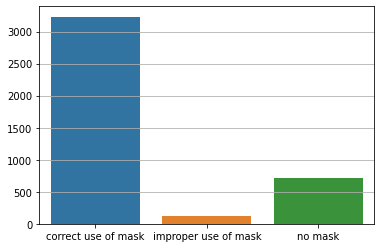

In [ ]:
ax = sns.barplot(x=["correct use of mask", "improper use of mask", "no mask"], y=[ok_mask, bad_mask, no_mask])
ax.grid(axis='y')

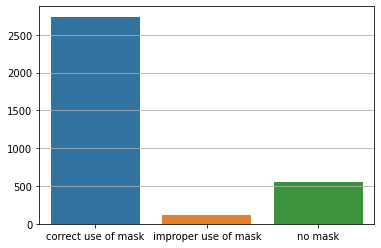

In [ ]:
ax = sns.barplot(x=["correct use of mask", "improper use of mask", "no mask"], y=[ok_mask-492, bad_mask-11, no_mask-162])
ax.grid(axis='y')

Data set is imbalanced

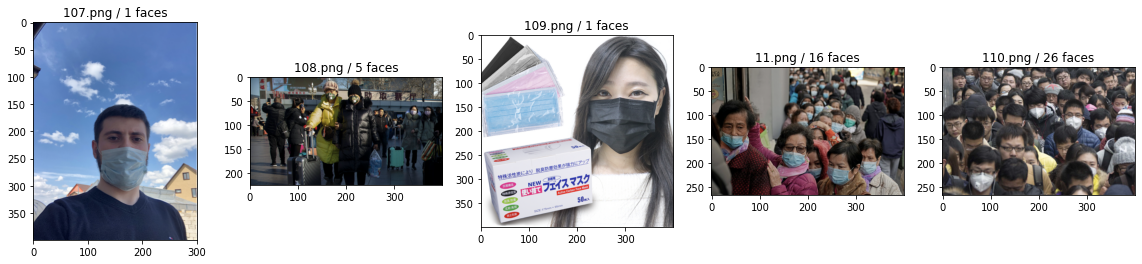

In [ ]:
# Let's preview couple of images

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(5*4, 4))

offset = 10
for index, file_name in enumerate(image_filenames[offset:offset+5]):
    im_f = zf.open('images/' + file_name)
    an_f = zf.open('annotations/' + annot_filenames[offset+index])
    hc = str(an_f.read()).count('</bndbox>')
    image = Image.open(im_f)
    axs[index].set_title(file_name[12:] + " / " + str(hc) + " faces")
    axs[index].imshow(image)
        
plt.show()

In [ ]:
def display_image_regions(image_idx=-1, image_num=-1, verbose=1):
    """ Display given image file and draw regions from its annotation.
        params: image_idx: index in the image_filenames list
                image_num: number in the name of the image file
                           if given it overrides image_idx
    """
    file_prefix = 'maksssksksss'
    if image_num !=-1:
        im_f = zf.open(f'images/{file_prefix}{str(image_num)}.png')
        an_f = zf.open(f'annotations/{file_prefix}{str(image_num)}.xml')
    else:
        im_f = zf.open('images/' + image_filenames[image_idx])
        an_f = zf.open('annotations/' + annot_filenames[image_idx])

    image = Image.open(im_f)
    # preserve original image because 'image' will be modified by drawing the rectangles
    image_orig = image.copy()

    # Parses XML document
    document = xml.dom.minidom.parse(an_f)
    
    # Gets root element of the document
    # doc_element = document.documentElement

    # Get list of regions (several of them)
    regions = document.getElementsByTagName("object")
    
    im_arr = []
    target_arr = []
    for index, region in enumerate(regions):
        # There is just one of each, so we can reference with [0].firstChild
        target_arr.append(region.getElementsByTagName("name")[0].firstChild.data)
        xmin   = int(region.getElementsByTagName("xmin")[0].firstChild.data)
        ymin   = int(region.getElementsByTagName("ymin")[0].firstChild.data)
        xmax   = int(region.getElementsByTagName("xmax")[0].firstChild.data)
        ymax   = int(region.getElementsByTagName("ymax")[0].firstChild.data)
        
        if verbose>0:
            print(f"Box[{index}] = [{xmin}, {ymin}, {xmax}, {ymax}]\tSize[{index}] = {xmax-xmin} x {ymax-ymin}  \tTarget[{index}] = {target_arr[index]}")
        
        # crop faces from the original (undrawn) image!
        im_arr.append(image_orig.crop((xmin, ymin, xmax, ymax)))

        # Now we'll draw the regions on the image
        image_draw = ImageDraw.Draw(image)
        image_draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="red")

        # And a number inside
        image_draw.text(
            (int((xmin+xmax)/2), int((ymin+ymax)/2)),
            str(index),
            fill ="red"
                    )

    return image, im_arr, target_arr

Box[0] = [99, 44, 116, 64]	Size[0] = 17 x 20  	Target[0] = with_mask
Box[1] = [151, 41, 171, 61]	Size[1] = 20 x 20  	Target[1] = with_mask
Box[2] = [306, 21, 326, 42]	Size[2] = 20 x 21  	Target[2] = with_mask
Box[3] = [354, 32, 357, 38]	Size[3] = 3 x 6  	Target[3] = with_mask
Box[4] = [275, 32, 277, 35]	Size[4] = 2 x 3  	Target[4] = without_mask
Box[5] = [243, 34, 246, 37]	Size[5] = 3 x 3  	Target[5] = with_mask
Box[6] = [207, 38, 208, 40]	Size[6] = 1 x 2  	Target[6] = with_mask
Box[7] = [216, 37, 218, 39]	Size[7] = 2 x 2  	Target[7] = with_mask
Box[8] = [217, 36, 219, 39]	Size[8] = 2 x 3  	Target[8] = with_mask
Box[9] = [226, 35, 227, 37]	Size[9] = 1 x 2  	Target[9] = with_mask
Box[10] = [230, 36, 231, 38]	Size[10] = 1 x 2  	Target[10] = with_mask


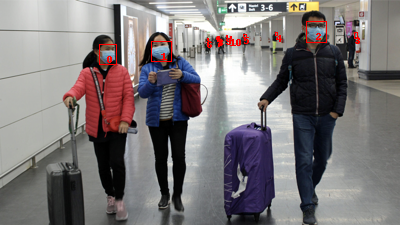

(400, 225)

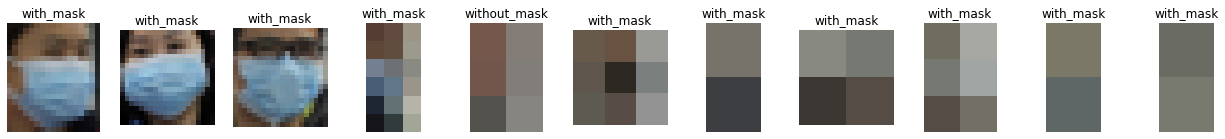

In [ ]:
#image, im_arr, target_arr = display_image_regions(image_idx = 167, image_num=158)
image, im_arr, target_arr = display_image_regions(image_idx = 601)

#image = image.transpose(Image.FLIP_LEFT_RIGHT)
image.show()

fig, axs = plt.subplots(ncols=len(im_arr), nrows=1, figsize=(len(im_arr)*2, 2))
if len(im_arr)>1:
    for index,im in enumerate(im_arr):
        axs[index].set_title(target_arr[index])
        axs[index].axis('off')
        axs[index].imshow(im)
else:
    plt.title(target_arr[0])
    plt.axis('off')
    plt.imshow(im_arr[0])

image.size[0], image.size[1]

In [ ]:
# collect all the annotated faces from the images
from PIL import ImageFilter

train_images = dict()
train_labels = dict()
test_images = dict()
test_labels = dict()
drop_labels = []

#all_sizes = []
h_max = 500
w_max = 500
n_serial = 0
image_counter = 0
drop_count = 0

for i in range(len(image_filenames)):
    _, im_arr, target_arr = display_image_regions(image_idx=i, verbose=0)
    for im_idx, im in enumerate(im_arr):
        w = im.size[0]
        h = im.size[1]

        if w > w_max:
            #w_max = w
            print(f"max_width changed to {w_max} \t image idx: {i} \t size: {w} x {h}")
        if h > h_max:
            h_max = h
            #print(f"max_heigth changed to {h_max} \t image idx: {i} \t size: {w} x {h}")
        
        # filter images which have an minimum area in pixels 156 is the 5% threshold
        threshold = 155
        if h*w >threshold:
            if image_counter%5 == 0:
                test_images[int(n_serial/4)] = im
                test_labels[int(n_serial/4)] = target_arr[im_idx]
            else:
                # do the image augmentation here
            
                train_images[10000 + n_serial] = im
                train_labels[10000 + n_serial] = target_arr[im_idx]
                # flip img horizontally
                train_images[20000 + n_serial] = im.transpose(Image.FLIP_LEFT_RIGHT)
                train_labels[20000 + n_serial] = target_arr[im_idx]
                # rotate img counter clockweise in the range of 0 to 45 grade
                train_images[30000 + n_serial] = im.rotate(45*(random.random())) 
                train_labels[30000 + n_serial] = target_arr[im_idx]
                # rotate img clockweise in the range of 0 to 45 grade
                train_images[40000 + n_serial] = im.rotate(-45*(random.random()))
                train_labels[40000 + n_serial] = target_arr[im_idx]
                # edge enancement
                train_images[50000 + n_serial] = im.filter(ImageFilter.EDGE_ENHANCE_MORE)
                train_labels[50000 + n_serial] = target_arr[im_idx]
                # a single channel(B&W)
                train_images[60000 + n_serial] = im.getchannel(0).transpose(Image.FLIP_LEFT_RIGHT)
                train_labels[60000 + n_serial] = target_arr[im_idx]
                                        
                n_serial += 1
            image_counter += 1
        else:
            drop_labels.append(target_arr[im_idx])
            drop_count +=1
print(w_max, h_max)
print(f"{drop_count} very small images has been dropped out")


500 500
665 very small images has been dropped out


In [ ]:
drop_labels.sort()
drop_labels.count('with_mask'), drop_labels.count('without_mask'), drop_labels.count('mask_weared_incorrect')

(492, 162, 11)

In [ ]:
drop_labels

['mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',


In [ ]:
16350*0.8


13080.0

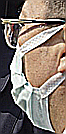

In [ ]:

im1 = im.filter(ImageFilter.CONTOUR)  #adjust_gamma(im, gamma=, gain=0.1)
im1 = im.filter(ImageFilter.EDGE_ENHANCE_MORE)
im1

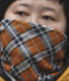

In [ ]:
train_images[20379]

In [ ]:
len(train_images), len(test_images), 16350/6 + 682 + drop_count

(16350, 682, 4072.0)

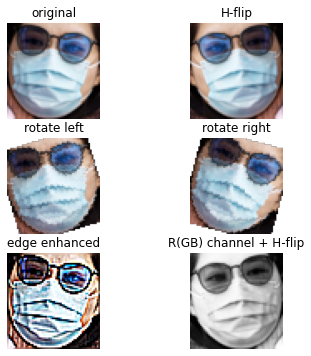

In [ ]:
import matplotlib.cm as cm

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(6, 6))
n = 10
for i in range(6):
    image = train_images[(i+1)*10000 + n]
    axs[int(i/2),i%2].set_title(['original', 'H-flip', 'rotate left', 'rotate right', 'edge enhanced', 'R(GB) channel + H-flip'][i])
    axs[int(i/2),i%2].axis('off')
    if i <5:
        axs[int(i/2),i%2].imshow(image)   
    else:
        axs[int(i/2),i%2].imshow(image, cmap = cm.Greys_r)
plt.show()   


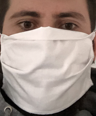

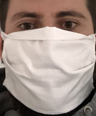

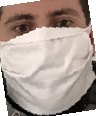

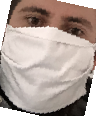

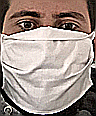

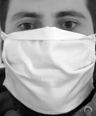

In [ ]:
n= 9
train_images[10000 + n].show()
train_images[20000 + n].show()
train_images[30000 + n].show()
train_images[40000 + n].show()
train_images[50000 + n].show()
train_images[60000 + n].show()

In [ ]:
for idx in range(len(test_images)):
    filename = 'im{0:05d}.png'.format(idx)
    test_images[idx].save(f'/work/test_images/{filename}')

In [ ]:
for key in train_images.keys():
    filename = 'im{0:05d}.png'.format(key)
    train_images[key].save(f'/work/train_images/{filename}')

In [ ]:
with open('/work/test_labels.txt', 'w') as f:
    for idx in range(len(test_labels)):
        label = test_labels[idx]
        f.write(f"{idx}:%s\n" % label)

In [ ]:
with open('/work/train_labels.txt', 'w') as f:
    for key in train_labels.keys():
        label = train_labels[key]
        f.write(f"{key}:%s\n" % label)

In [ ]:
2725 + 682 + drop_count

4071

In [ ]:
# use the pretrained model vgg16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# load model without classifier layers
model1 = VGG16(include_top=False, input_shape=(224, 224, 3))

# add new classifier layers
# here we can define at which layer of the pretrained model we attach our layers
cnn = Conv2D(filters=10, kernel_size=(3,3), padding="same", activation="relu")(model1.layers[-2].output)
flat1 = Flatten()(cnn)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model1 = Model(inputs=model1.inputs, outputs=output)
# summarize
model1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a109ea11-a7da-42aa-8af0-3a0cdafc917e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>